## This notebook is to extract and save data into hdf5 format (using .json parameters)

## 1. Import module, parameter file, and sorted spikes

### 1-01. Import modules & path to .json file

In [1]:
JSON_FILE_IDX = 10

In [2]:
SAVE_TO_HDF5 = 1
SAVE_SPIKES_TO_PICKLE = 0

In [3]:
import sys
sys.path.append('../')
if sys.platform == 'darwin':
    MAC0_OR_LINUX1 = 0
else:
    MAC0_OR_LINUX1 = 1

In [4]:
if MAC0_OR_LINUX1 == 1:
    home_dir = '/home'
elif MAC0_OR_LINUX1 == 0:
    home_dir = '/Users'
proj_dir = home_dir + '/dlee/moving-bar/'

In [82]:
import numpy as np
import scipy.signal
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

import pyret.spiketools as spk
import pyret.stimulustools as st
import pyret.filtertools as ft
import extract as ext
import utils
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
stim_sort_total_list = np.array(['flash_1', 'rf_wn', 'mb_ns', 'mb_ad', 'mb_da', 
                                 'mb_2ad', 'mb_4ad', 'mb_2da', 'mb_4da', 'rf_30m'])
stim_notforsort_total_list = np.array(['line_w4', 'line_w8', 'rf_5m', 'mb', 'flash_2'])
stim_inj_total_list = np.array(['mb_ad_ao'])

In [7]:
fs = 10000.0    # sampling rate of data acquisition [Hz]
fr = 1/60       # frame rate of stimulus            [Hz]

### 1-02. Load .json file

In [8]:
json_file_list = ['17-10-18.json', '17-10-20.json', '17-10-26.json', '17-10-26-1.json', '17-10-27.json',
                  '17-11-06.json', '17-11-07.json', '17-11-08.json', '17-11-14.json', '17-11-14-1.json',
                  '17-11-29.json', '18-03-12.json', '18-03-22.json', '18-03-23.json', '18-03-24.json',
                  '18-03-24-1.json', '18-03-27.json', '18-04-23.json']
json_file = json_file_list[JSON_FILE_IDX]
#json_file

In [9]:
with open(proj_dir + 'json/sort2/' + 'config.json', 'r') as js:
    config = json.load(js)
with open(proj_dir + 'json/sort2/' + json_file, 'r') as js:
    p = json.load(js)
#p

In [10]:
data_dir = proj_dir + config['data_sort_dir']

In [11]:
lr_idx = np.array([1, 0, 0, 1, 1, 0, 0, 1])
rl_idx = 1 - lr_idx
mb_idx = np.array([1, 1, 1, 1, 1])
if p['exp_version'] == 1:
    con_idx = np.array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    pb1_idx = np.array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0])
    pb2_idx = np.array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1])
elif p['exp_version'] == 2:
    con_idx = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])
    pb1_idx = np.array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])
    pb2_idx = np.array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])

### 1-03. Convert .txt file to array (spike time)

In [12]:
spikes = ext.txt2array(data_dir + p['exp_name'] + '/' + config['sort_version'] + '/',
                       p['sort_exp_num'] * p['g_cell_num'])
#for i in range(len(spikes)):
#    print(spikes[i].shape[0], end=' ')

### 1-04. Store spikes time to each variable for sorted experiment

In [13]:
stim_sort_total_list_idx = np.array([p[stim_sort_total_list[i]] for i in range(len(stim_sort_total_list))])
stim_sort_list = stim_sort_total_list[stim_sort_total_list_idx==1]
stim_sort_list

array(['flash_1', 'mb_ad', 'mb_da', 'rf_30m'], dtype='<U7')

In [14]:
for i in range(p['sort_exp_num']):
    vars()[('spikes_' + stim_sort_list[i])] = []
    for c in range(p['g_cell_num']):
        vars()[('spikes_' + stim_sort_list[i])].append(spikes[c * p['sort_exp_num'] + i])

## 2. Sorted experiment

### 2-01. Load 'flash_1' session

In [15]:
if p['flash_1'] == 1:
    name_flash_1 = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'flash_1')
    pd_flash_1 = ext.photodiode(data_dir + p['exp_name'] + '/' + name_flash_1)
    elec_flash_1 = ext.electrode(data_dir + p['exp_name'] + '/' + name_flash_1)
    
    maxtab_flash_1, _ = spk.peakdet(pd_flash_1, p['flash_1_th'])
    
    elec_ext_flash_1 = ext.split_trial(elec_flash_1, maxtab_flash_1, 
                                   start=0, last=20, every=2, per=2, sample_rate=fs, mode='continuous')
    spikes_ext_flash_1 = []
    for cell in range(p['g_cell_num']):
        spikes_ext_flash_1.append(ext.split_trial(spikes_flash_1[cell], maxtab_flash_1, 
                                                  start=0, last=20, every=2, per=2, sample_rate=fs, mode='discrete'))
    tbins_flash_1 = np.arange(0, 122 * fr, fr)
    bspk_flash_1 = np.stack([np.stack([spk.binspikes(spikes_ext_flash_1[cell][trial], tbins_flash_1) 
                                       for trial in range(10)]) 
                             for cell in range(p['g_cell_num'])])
    stim_flash_1 = np.concatenate((np.ones(61), np.zeros(61)))
    intra_flash_1 = ext.list_to_array(elec_ext_flash_1, ndim=1)
else:
    stim_flash_1 = np.nan
    bspk_flash_1 = np.nan
    intra_flash_1 = np.nan
    tbins_flash_1 = np.nan

### 2-02. Load 'rf_wn' session

In [16]:
if p['rf_wn'] == 1:
    name_rf_wn = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'rf_wn')
    pd_rf_wn = ext.photodiode(data_dir + p['exp_name'] + '/' + name_rf_wn)
    elec_rf_wn = ext.electrode(data_dir + p['exp_name'] + '/' + name_rf_wn)
    
    maxtab_rf_wn, _ = spk.peakdet(pd_rf_wn, p['rf_wn_th'])
    
    us_factor_rf_wn = 8
    elec_ext_rf_wn = ext.split_trial(elec_rf_wn, maxtab_rf_wn, 
                                     start=0, last=2, every=2, per=2, sample_rate=fs, mode='continuous')
    spikes_ext_rf_wn = []
    for cell in range(p['g_cell_num']):
        spikes_ext_rf_wn.append(ext.split_trial(spikes_rf_wn[cell], maxtab_rf_wn, 
                                                start=0, last=2, every=2, per=2, sample_rate=fs, mode='discrete'))
    tbins_rf_wn = np.linspace(0, elec_ext_rf_wn[0].shape[0]/fs, us_factor_rf_wn * 9000 + 1)[:-1]
    bspk_rf_wn = np.stack([spk.binspikes(spikes_ext_rf_wn[cell][0], tbins_rf_wn)
                           for cell in range(p['g_cell_num'])])
    stim_rf_wn = ext.load_stimulus('2d_st_bin_wn_w8', mode='mono', two_dim=True)[:9000, :, :]
    
    stim_us_rf_wn = st.upsample(stim_rf_wn, us_factor_rf_wn)[0]
    #stim_us_rf_wn -= np.mean(stim_us_rf_wn)
    #stim_us_rf_wn /= np.std(stim_us_rf_wn)
    stim_us_rf_wn -= 0.5
    stim_us_rf_wn *= 2
    stas_rf_wn = []
    for cell in range(p['g_cell_num']):
        sta_rf_wn, tax_rf_wn = ft.sta(tbins_rf_wn, stim_us_rf_wn, spikes_ext_rf_wn[cell][0], us_factor_rf_wn*15)
        stas_rf_wn.append(sta_rf_wn)
    stim_us_rf_wn = stim_us_rf_wn.astype(int)
else:
    stim_us_rf_wn = np.nan
    bspk_rf_wn = np.nan
    inj_ext_rs_rf_wn = np.nan
    tbins_rf_wn = np.nan

### 2-03. Load 'mb_ns' session

In [17]:
if p['mb_ns'] == 1:
    name_mb_ns = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'mb_ns')
    pd_mb_ns = ext.photodiode(data_dir + p['exp_name'] + '/' + name_mb_ns)
    elec_mb_ns = ext.electrode(data_dir + p['exp_name'] + '/' + name_mb_ns)
    
    maxtab_mb_ns, _ = spk.peakdet(pd_mb_ns, p['mb_ns_th'])

    N_mb_ns = maxtab_mb_ns.shape[0]
    elec_ext_mb_ns = ext.split_trial(elec_mb_ns, maxtab_mb_ns, 
                                     start=0, last=N_mb_ns, every=2, per=1, 
                                     sample_rate=fs, mode='continuous')
    spikes_ext_mb_ns = []
    for cell in range(p['g_cell_num']):
        spikes_ext_mb_ns.append(ext.split_trial(spikes_mb_ns[cell], maxtab_mb_ns, 
                                                start=0, last=N_mb_ns, every=2, per=1, 
                                                sample_rate=fs, mode='discrete'))
    tbins_mb_ns = np.arange(0, 129 * fr, fr)
    bspk_mb_ns = np.stack([np.stack([spk.binspikes(spikes_ext_mb_ns[cell][trial], tbins_mb_ns) 
                                     for trial in range(int(N_mb_ns/2))]) 
                           for cell in range(p['g_cell_num'])])
    
    mb_ns_amp_lr_idx = np.array([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    mb_ns_dim_lr_idx = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1])
    mb_ns_amp_rl_idx = np.array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    mb_ns_dim_rl_idx = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0])
    bspk_mb_ns_amp_lr = np.transpose(np.transpose(bspk_mb_ns, [1, 2, 0])[mb_ns_amp_lr_idx == 1], [2, 0, 1])
    bspk_mb_ns_dim_lr = np.transpose(np.transpose(bspk_mb_ns, [1, 2, 0])[mb_ns_dim_lr_idx == 1], [2, 0, 1])
    bspk_mb_ns_amp_rl = np.transpose(np.transpose(bspk_mb_ns, [1, 2, 0])[mb_ns_amp_rl_idx == 1], [2, 0, 1])
    bspk_mb_ns_dim_rl = np.transpose(np.transpose(bspk_mb_ns, [1, 2, 0])[mb_ns_dim_rl_idx == 1], [2, 0, 1])
    
    bspk_total_mb_ns = np.stack(
        [np.stack([bspk_mb_ns_amp_lr, bspk_mb_ns_dim_lr], axis=1),
         np.stack([bspk_mb_ns_amp_rl, bspk_mb_ns_dim_rl], axis=1)], axis=1)
else:
    bspk_total_mb_ns = np.nan
    tbins_mb_ns = np.nan

### 2-04. Load 'mb_ad' session

In [18]:
if p['mb_ad'] == 1:
    name_mb_ad = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'mb_ad')
    pd_mb_ad = ext.photodiode(data_dir + p['exp_name'] + '/' + name_mb_ad)
    elec_mb_ad = ext.electrode(data_dir + p['exp_name'] + '/' + name_mb_ad)

    maxtab_mb_ad, _ = spk.peakdet(pd_mb_ad, p['mb_ad_th'])

    N_mb_ad = maxtab_mb_ad.shape[0]
    elec_ext_mb_ad = ext.split_trial(elec_mb_ad, maxtab_mb_ad, 
                                     start=0, last=N_mb_ad, every=2, per=1, 
                                     sample_rate=fs, mode='continuous')
    spikes_ext_mb_ad = []
    for cell in range(p['g_cell_num']):
        spikes_ext_mb_ad.append(ext.split_trial(spikes_mb_ad[cell], maxtab_mb_ad, 
                                                start=0, last=N_mb_ad, every=2, per=1, 
                                                sample_rate=fs, mode='discrete'))
    tbins_mb_ad = np.arange(0, 129 * fr, fr)
    bspk_mb_ad = np.stack([np.stack([spk.binspikes(spikes_ext_mb_ad[cell][trial], tbins_mb_ad) 
                                     for trial in range(int(N_mb_ad/2))]) 
                           for cell in range(p['g_cell_num'])])

    mb_ad_con_lr_idx = np.outer(con_idx, lr_idx).reshape(-1)
    mb_ad_amp_lr_idx = np.outer(pb1_idx, lr_idx).reshape(-1)
    mb_ad_dim_lr_idx = np.outer(pb2_idx, lr_idx).reshape(-1)
    mb_ad_con_rl_idx = np.outer(con_idx, rl_idx).reshape(-1)
    mb_ad_amp_rl_idx = np.outer(pb1_idx, rl_idx).reshape(-1)
    mb_ad_dim_rl_idx = np.outer(pb2_idx, rl_idx).reshape(-1)
    bspk_mb_ad_con_lr = np.transpose(np.transpose(bspk_mb_ad, [1, 2, 0])[mb_ad_con_lr_idx == 1], [2, 0, 1])
    bspk_mb_ad_amp_lr = np.transpose(np.transpose(bspk_mb_ad, [1, 2, 0])[mb_ad_amp_lr_idx == 1], [2, 0, 1])
    bspk_mb_ad_dim_lr = np.transpose(np.transpose(bspk_mb_ad, [1, 2, 0])[mb_ad_dim_lr_idx == 1], [2, 0, 1])
    bspk_mb_ad_con_rl = np.transpose(np.transpose(bspk_mb_ad, [1, 2, 0])[mb_ad_con_rl_idx == 1], [2, 0, 1])
    bspk_mb_ad_amp_rl = np.transpose(np.transpose(bspk_mb_ad, [1, 2, 0])[mb_ad_amp_rl_idx == 1], [2, 0, 1])
    bspk_mb_ad_dim_rl = np.transpose(np.transpose(bspk_mb_ad, [1, 2, 0])[mb_ad_dim_rl_idx == 1], [2, 0, 1])

    if p['exp_version'] == 1:
        bspk_total_mb_ad = np.stack(
            [np.stack([np.hstack([bspk_mb_ad_con_lr, np.full(bspk_mb_ad_con_lr.shape, np.nan)]), 
                       bspk_mb_ad_amp_lr, bspk_mb_ad_dim_lr], axis=1),
             np.stack([np.hstack([bspk_mb_ad_con_rl, np.full(bspk_mb_ad_con_rl.shape, np.nan)]), 
                       bspk_mb_ad_amp_rl, bspk_mb_ad_dim_rl], axis=1)], axis=1)
    else:
        bspk_total_mb_ad = np.stack(
            [np.stack([bspk_mb_ad_con_lr, bspk_mb_ad_amp_lr, bspk_mb_ad_dim_lr], axis=1),
             np.stack([bspk_mb_ad_con_rl, bspk_mb_ad_amp_rl, bspk_mb_ad_dim_rl], axis=1)], axis=1)
else:
    bspk_total_mb_ad = np.nan
    tbins_mb_ad = np.nan

### 2-05. Load 'mb_da' session

In [19]:
if p['mb_da'] == 1:
    name_mb_da = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'mb_da')
    pd_mb_da = ext.photodiode(data_dir + p['exp_name'] + '/' + name_mb_da)
    elec_mb_da = ext.electrode(data_dir + p['exp_name'] + '/' + name_mb_da)

    maxtab_mb_da, _ = spk.peakdet(pd_mb_da, p['mb_da_th'])

    N_mb_da = maxtab_mb_da.shape[0]
    elec_ext_mb_da = ext.split_trial(elec_mb_da, maxtab_mb_da, 
                                     start=0, last=N_mb_da, every=2, per=1, 
                                     sample_rate=fs, mode='continuous')
    spikes_ext_mb_da = []
    for cell in range(p['g_cell_num']):
        spikes_ext_mb_da.append(ext.split_trial(spikes_mb_da[cell], maxtab_mb_da, 
                                                start=0, last=N_mb_da, every=2, per=1, 
                                                sample_rate=fs, mode='discrete'))
    tbins_mb_da = np.arange(0, 129 * fr, fr)
    bspk_mb_da = np.stack([np.stack([spk.binspikes(spikes_ext_mb_da[cell][trial], tbins_mb_da) 
                                     for trial in range(int(N_mb_da/2))]) 
                           for cell in range(p['g_cell_num'])])

    mb_da_con_lr_idx = np.outer(con_idx, lr_idx).reshape(-1)
    mb_da_amp_lr_idx = np.outer(pb2_idx, lr_idx).reshape(-1)
    mb_da_dim_lr_idx = np.outer(pb1_idx, lr_idx).reshape(-1)
    mb_da_con_rl_idx = np.outer(con_idx, rl_idx).reshape(-1)
    mb_da_amp_rl_idx = np.outer(pb2_idx, rl_idx).reshape(-1)
    mb_da_dim_rl_idx = np.outer(pb1_idx, rl_idx).reshape(-1)
    bspk_mb_da_con_lr = np.transpose(np.transpose(bspk_mb_da, [1, 2, 0])[mb_da_con_lr_idx == 1], [2, 0, 1])
    bspk_mb_da_amp_lr = np.transpose(np.transpose(bspk_mb_da, [1, 2, 0])[mb_da_amp_lr_idx == 1], [2, 0, 1])
    bspk_mb_da_dim_lr = np.transpose(np.transpose(bspk_mb_da, [1, 2, 0])[mb_da_dim_lr_idx == 1], [2, 0, 1])
    bspk_mb_da_con_rl = np.transpose(np.transpose(bspk_mb_da, [1, 2, 0])[mb_da_con_rl_idx == 1], [2, 0, 1])
    bspk_mb_da_amp_rl = np.transpose(np.transpose(bspk_mb_da, [1, 2, 0])[mb_da_amp_rl_idx == 1], [2, 0, 1])
    bspk_mb_da_dim_rl = np.transpose(np.transpose(bspk_mb_da, [1, 2, 0])[mb_da_dim_rl_idx == 1], [2, 0, 1])

    if p['exp_version'] == 1:
        bspk_total_mb_da = np.stack(
            [np.stack([np.hstack([bspk_mb_da_con_lr, np.full(bspk_mb_da_con_lr.shape, np.nan)]), 
                       bspk_mb_da_amp_lr, bspk_mb_da_dim_lr], axis=1),
             np.stack([np.hstack([bspk_mb_da_con_rl, np.full(bspk_mb_da_con_rl.shape, np.nan)]), 
                       bspk_mb_da_amp_rl, bspk_mb_da_dim_rl], axis=1)], axis=1)
    else:
        bspk_total_mb_da = np.stack(
            [np.stack([bspk_mb_da_con_lr, bspk_mb_da_amp_lr, bspk_mb_da_dim_lr], axis=1),
             np.stack([bspk_mb_da_con_rl, bspk_mb_da_amp_rl, bspk_mb_da_dim_rl], axis=1)], axis=1)
else:
    bspk_total_mb_da = np.nan
    tbins_mb_da = np.nan

### 2-06. Load 'mb_2ad' session

In [20]:
if p['mb_2ad'] == 1:
    name_mb_2ad = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'mb_2ad')
    pd_mb_2ad = ext.photodiode(data_dir + p['exp_name'] + '/' + name_mb_2ad)
    elec_mb_2ad = ext.electrode(data_dir + p['exp_name'] + '/' + name_mb_2ad)

    maxtab_mb_2ad, _ = spk.peakdet(pd_mb_2ad, p['mb_2ad_th'])

    N_mb_2ad = maxtab_mb_2ad.shape[0]
    elec_ext_mb_2ad = ext.split_trial(elec_mb_2ad, maxtab_mb_2ad, 
                                      start=0, last=N_mb_2ad, every=2, per=1, 
                                      sample_rate=fs, mode='continuous')
    spikes_ext_mb_2ad = []
    for cell in range(p['g_cell_num']):
        spikes_ext_mb_2ad.append(ext.split_trial(spikes_mb_2ad[cell], maxtab_mb_2ad, 
                                                 start=0, last=N_mb_2ad, every=2, per=1, 
                                                 sample_rate=fs, mode='discrete'))
    tbins_mb_2ad = np.arange(0, 129 * fr, fr)
    bspk_mb_2ad = np.stack([np.stack([spk.binspikes(spikes_ext_mb_2ad[cell][trial], tbins_mb_2ad) 
                                      for trial in range(int(N_mb_2ad/2))]) 
                           for cell in range(p['g_cell_num'])])

    mb_2ad_con_lr_idx = np.outer(con_idx, lr_idx).reshape(-1)
    mb_2ad_amp_lr_idx = np.outer(pb1_idx, lr_idx).reshape(-1)
    mb_2ad_dim_lr_idx = np.outer(pb2_idx, lr_idx).reshape(-1)
    mb_2ad_con_rl_idx = np.outer(con_idx, rl_idx).reshape(-1)
    mb_2ad_amp_rl_idx = np.outer(pb1_idx, rl_idx).reshape(-1)
    mb_2ad_dim_rl_idx = np.outer(pb2_idx, rl_idx).reshape(-1)
    bspk_mb_2ad_con_lr = np.transpose(np.transpose(bspk_mb_2ad, [1, 2, 0])[mb_2ad_con_lr_idx == 1], [2, 0, 1])
    bspk_mb_2ad_amp_lr = np.transpose(np.transpose(bspk_mb_2ad, [1, 2, 0])[mb_2ad_amp_lr_idx == 1], [2, 0, 1])
    bspk_mb_2ad_dim_lr = np.transpose(np.transpose(bspk_mb_2ad, [1, 2, 0])[mb_2ad_dim_lr_idx == 1], [2, 0, 1])
    bspk_mb_2ad_con_rl = np.transpose(np.transpose(bspk_mb_2ad, [1, 2, 0])[mb_2ad_con_rl_idx == 1], [2, 0, 1])
    bspk_mb_2ad_amp_rl = np.transpose(np.transpose(bspk_mb_2ad, [1, 2, 0])[mb_2ad_amp_rl_idx == 1], [2, 0, 1])
    bspk_mb_2ad_dim_rl = np.transpose(np.transpose(bspk_mb_2ad, [1, 2, 0])[mb_2ad_dim_rl_idx == 1], [2, 0, 1])

    if p['exp_version'] == 1:
        bspk_total_mb_2ad = np.stack(
            [np.stack([np.hstack([bspk_mb_2ad_con_lr, np.full(bspk_mb_2ad_con_lr.shape, np.nan)]), 
                       bspk_mb_2ad_amp_lr, bspk_mb_2ad_dim_lr], axis=1),
             np.stack([np.hstack([bspk_mb_2ad_con_rl, np.full(bspk_mb_2ad_con_rl.shape, np.nan)]), 
                       bspk_mb_2ad_amp_rl, bspk_mb_2ad_dim_rl], axis=1)], axis=1)
    else:
        bspk_total_mb_2ad = np.stack(
            [np.stack([bspk_mb_2ad_con_lr, bspk_mb_2ad_amp_lr, bspk_mb_2ad_dim_lr], axis=1),
             np.stack([bspk_mb_2ad_con_rl, bspk_mb_2ad_amp_rl, bspk_mb_2ad_dim_rl], axis=1)], axis=1)
else:
    bspk_total_mb_2ad = np.nan
    tbins_mb_2ad = np.nan

### 2-07. Load 'mb_4ad' session

In [21]:
if p['mb_4ad'] == 1:
    name_mb_4ad = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'mb_4ad')
    pd_mb_4ad = ext.photodiode(data_dir + p['exp_name'] + '/' + name_mb_4ad)
    elec_mb_4ad = ext.electrode(data_dir + p['exp_name'] + '/' + name_mb_4ad)

    maxtab_mb_4ad, _ = spk.peakdet(pd_mb_4ad, p['mb_4ad_th'])

    N_mb_4ad = maxtab_mb_4ad.shape[0]
    elec_ext_mb_4ad = ext.split_trial(elec_mb_4ad, maxtab_mb_4ad, 
                                      start=0, last=N_mb_4ad, every=2, per=1, 
                                      sample_rate=fs, mode='continuous')
    spikes_ext_mb_4ad = []
    for cell in range(p['g_cell_num']):
        spikes_ext_mb_4ad.append(ext.split_trial(spikes_mb_4ad[cell], maxtab_mb_4ad, 
                                                 start=0, last=N_mb_4ad, every=2, per=1, 
                                                 sample_rate=fs, mode='discrete'))
    tbins_mb_4ad = np.arange(0, 129 * fr, fr)
    bspk_mb_4ad = np.stack([np.stack([spk.binspikes(spikes_ext_mb_4ad[cell][trial], tbins_mb_4ad) 
                                      for trial in range(int(N_mb_4ad/2))]) 
                           for cell in range(p['g_cell_num'])])

    mb_4ad_con_lr_idx = np.outer(con_idx, lr_idx).reshape(-1)
    mb_4ad_amp_lr_idx = np.outer(pb1_idx, lr_idx).reshape(-1)
    mb_4ad_dim_lr_idx = np.outer(pb2_idx, lr_idx).reshape(-1)
    mb_4ad_con_rl_idx = np.outer(con_idx, rl_idx).reshape(-1)
    mb_4ad_amp_rl_idx = np.outer(pb1_idx, rl_idx).reshape(-1)
    mb_4ad_dim_rl_idx = np.outer(pb2_idx, rl_idx).reshape(-1)
    bspk_mb_4ad_con_lr = np.transpose(np.transpose(bspk_mb_4ad, [1, 2, 0])[mb_4ad_con_lr_idx == 1], [2, 0, 1])
    bspk_mb_4ad_amp_lr = np.transpose(np.transpose(bspk_mb_4ad, [1, 2, 0])[mb_4ad_amp_lr_idx == 1], [2, 0, 1])
    bspk_mb_4ad_dim_lr = np.transpose(np.transpose(bspk_mb_4ad, [1, 2, 0])[mb_4ad_dim_lr_idx == 1], [2, 0, 1])
    bspk_mb_4ad_con_rl = np.transpose(np.transpose(bspk_mb_4ad, [1, 2, 0])[mb_4ad_con_rl_idx == 1], [2, 0, 1])
    bspk_mb_4ad_amp_rl = np.transpose(np.transpose(bspk_mb_4ad, [1, 2, 0])[mb_4ad_amp_rl_idx == 1], [2, 0, 1])
    bspk_mb_4ad_dim_rl = np.transpose(np.transpose(bspk_mb_4ad, [1, 2, 0])[mb_4ad_dim_rl_idx == 1], [2, 0, 1])

    if p['exp_version'] == 1:
        bspk_total_mb_4ad = np.stack(
            [np.stack([np.hstack([bspk_mb_4ad_con_lr, np.full(bspk_mb_4ad_con_lr.shape, np.nan)]), 
                       bspk_mb_4ad_amp_lr, bspk_mb_4ad_dim_lr], axis=1),
             np.stack([np.hstack([bspk_mb_4ad_con_rl, np.full(bspk_mb_4ad_con_rl.shape, np.nan)]), 
                       bspk_mb_4ad_amp_rl, bspk_mb_4ad_dim_rl], axis=1)], axis=1)
    else:
        bspk_total_mb_4ad = np.stack(
            [np.stack([bspk_mb_4ad_con_lr, bspk_mb_4ad_amp_lr, bspk_mb_4ad_dim_lr], axis=1),
             np.stack([bspk_mb_4ad_con_rl, bspk_mb_4ad_amp_rl, bspk_mb_4ad_dim_rl], axis=1)], axis=1)
else:
    bspk_total_mb_4ad = np.nan
    tbins_mb_4ad = np.nan

### 2-08. Load 'mb_2da' session

In [22]:
if p['mb_2da'] == 1:
    name_mb_2da = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'mb_2da')
    pd_mb_2da = ext.photodiode(data_dir + p['exp_name'] + '/' + name_mb_2da)
    elec_mb_2da = ext.electrode(data_dir + p['exp_name'] + '/' + name_mb_2da)

    maxtab_mb_2da, _ = spk.peakdet(pd_mb_2da, p['mb_2da_th'])

    N_mb_2da = maxtab_mb_2da.shape[0]
    elec_ext_mb_2da = ext.split_trial(elec_mb_2da, maxtab_mb_2da, 
                                      start=0, last=N_mb_2da, every=2, per=1, 
                                      sample_rate=fs, mode='continuous')
    spikes_ext_mb_2da = []
    for cell in range(p['g_cell_num']):
        spikes_ext_mb_2da.append(ext.split_trial(spikes_mb_2da[cell], maxtab_mb_2da, 
                                                 start=0, last=N_mb_2da, every=2, per=1, 
                                                 sample_rate=fs, mode='discrete'))
    tbins_mb_2da = np.arange(0, 129 * fr, fr)
    bspk_mb_2da = np.stack([np.stack([spk.binspikes(spikes_ext_mb_2da[cell][trial], tbins_mb_2da) 
                                     for trial in range(int(N_mb_2da/2))]) 
                           for cell in range(p['g_cell_num'])])

    mb_2da_con_lr_idx = np.outer(con_idx, lr_idx).reshape(-1)
    mb_2da_amp_lr_idx = np.outer(pb2_idx, lr_idx).reshape(-1)
    mb_2da_dim_lr_idx = np.outer(pb1_idx, lr_idx).reshape(-1)
    mb_2da_con_rl_idx = np.outer(con_idx, rl_idx).reshape(-1)
    mb_2da_amp_rl_idx = np.outer(pb2_idx, rl_idx).reshape(-1)
    mb_2da_dim_rl_idx = np.outer(pb1_idx, rl_idx).reshape(-1)
    bspk_mb_2da_con_lr = np.transpose(np.transpose(bspk_mb_2da, [1, 2, 0])[mb_2da_con_lr_idx == 1], [2, 0, 1])
    bspk_mb_2da_amp_lr = np.transpose(np.transpose(bspk_mb_2da, [1, 2, 0])[mb_2da_amp_lr_idx == 1], [2, 0, 1])
    bspk_mb_2da_dim_lr = np.transpose(np.transpose(bspk_mb_2da, [1, 2, 0])[mb_2da_dim_lr_idx == 1], [2, 0, 1])
    bspk_mb_2da_con_rl = np.transpose(np.transpose(bspk_mb_2da, [1, 2, 0])[mb_2da_con_rl_idx == 1], [2, 0, 1])
    bspk_mb_2da_amp_rl = np.transpose(np.transpose(bspk_mb_2da, [1, 2, 0])[mb_2da_amp_rl_idx == 1], [2, 0, 1])
    bspk_mb_2da_dim_rl = np.transpose(np.transpose(bspk_mb_2da, [1, 2, 0])[mb_2da_dim_rl_idx == 1], [2, 0, 1])

    if p['exp_version'] == 1:
        bspk_total_mb_2da = np.stack(
            [np.stack([np.hstack([bspk_mb_2da_con_lr, np.full(bspk_mb_2da_con_lr.shape, np.nan)]), 
                       bspk_mb_2da_amp_lr, bspk_mb_2da_dim_lr], axis=1),
             np.stack([np.hstack([bspk_mb_2da_con_rl, np.full(bspk_mb_2da_con_rl.shape, np.nan)]), 
                       bspk_mb_2da_amp_rl, bspk_mb_2da_dim_rl], axis=1)], axis=1)
    else:
        bspk_total_mb_2da = np.stack(
            [np.stack([bspk_mb_2da_con_lr, bspk_mb_2da_amp_lr, bspk_mb_2da_dim_lr], axis=1),
             np.stack([bspk_mb_2da_con_rl, bspk_mb_2da_amp_rl, bspk_mb_2da_dim_rl], axis=1)], axis=1)
else:
    bspk_total_mb_2da = np.nan
    tbins_mb_2da = np.nan

### 2-09. Load 'mb_4da' session

In [23]:
if p['mb_4da'] == 1:
    name_mb_4da = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'mb_4da')
    pd_mb_4da = ext.photodiode(data_dir + p['exp_name'] + '/' + name_mb_4da)
    elec_mb_4da = ext.electrode(data_dir + p['exp_name'] + '/' + name_mb_4da)

    maxtab_mb_4da, _ = spk.peakdet(pd_mb_4da, p['mb_4da_th'])

    N_mb_4da = maxtab_mb_4da.shape[0]
    elec_ext_mb_4da = ext.split_trial(elec_mb_4da, maxtab_mb_4da, 
                                      start=0, last=N_mb_4da, every=2, per=1, 
                                      sample_rate=fs, mode='continuous')
    spikes_ext_mb_4da = []
    for cell in range(p['g_cell_num']):
        spikes_ext_mb_4da.append(ext.split_trial(spikes_mb_4da[cell], maxtab_mb_4da, 
                                                 start=0, last=N_mb_4da, every=2, per=1, 
                                                 sample_rate=fs, mode='discrete'))
    tbins_mb_4da = np.arange(0, 129 * fr, fr)
    bspk_mb_4da = np.stack([np.stack([spk.binspikes(spikes_ext_mb_4da[cell][trial], tbins_mb_4da) 
                                     for trial in range(int(N_mb_4da/2))]) 
                           for cell in range(p['g_cell_num'])])

    mb_4da_con_lr_idx = np.outer(con_idx, lr_idx).reshape(-1)
    mb_4da_amp_lr_idx = np.outer(pb2_idx, lr_idx).reshape(-1)
    mb_4da_dim_lr_idx = np.outer(pb1_idx, lr_idx).reshape(-1)
    mb_4da_con_rl_idx = np.outer(con_idx, rl_idx).reshape(-1)
    mb_4da_amp_rl_idx = np.outer(pb2_idx, rl_idx).reshape(-1)
    mb_4da_dim_rl_idx = np.outer(pb1_idx, rl_idx).reshape(-1)
    bspk_mb_4da_con_lr = np.transpose(np.transpose(bspk_mb_4da, [1, 2, 0])[mb_4da_con_lr_idx == 1], [2, 0, 1])
    bspk_mb_4da_amp_lr = np.transpose(np.transpose(bspk_mb_4da, [1, 2, 0])[mb_4da_amp_lr_idx == 1], [2, 0, 1])
    bspk_mb_4da_dim_lr = np.transpose(np.transpose(bspk_mb_4da, [1, 2, 0])[mb_4da_dim_lr_idx == 1], [2, 0, 1])
    bspk_mb_4da_con_rl = np.transpose(np.transpose(bspk_mb_4da, [1, 2, 0])[mb_4da_con_rl_idx == 1], [2, 0, 1])
    bspk_mb_4da_amp_rl = np.transpose(np.transpose(bspk_mb_4da, [1, 2, 0])[mb_4da_amp_rl_idx == 1], [2, 0, 1])
    bspk_mb_4da_dim_rl = np.transpose(np.transpose(bspk_mb_4da, [1, 2, 0])[mb_4da_dim_rl_idx == 1], [2, 0, 1])

    if p['exp_version'] == 1:
        bspk_total_mb_4da = np.stack(
            [np.stack([np.hstack([bspk_mb_4da_con_lr, np.full(bspk_mb_4da_con_lr.shape, np.nan)]), 
                       bspk_mb_4da_amp_lr, bspk_mb_4da_dim_lr], axis=1),
             np.stack([np.hstack([bspk_mb_4da_con_rl, np.full(bspk_mb_4da_con_rl.shape, np.nan)]), 
                       bspk_mb_4da_amp_rl, bspk_mb_4da_dim_rl], axis=1)], axis=1)
    else:
        bspk_total_mb_4da = np.stack(
            [np.stack([bspk_mb_4da_con_lr, bspk_mb_4da_amp_lr, bspk_mb_4da_dim_lr], axis=1),
             np.stack([bspk_mb_4da_con_rl, bspk_mb_4da_amp_rl, bspk_mb_4da_dim_rl], axis=1)], axis=1)
else:
    bspk_total_mb_4da = np.nan
    tbins_mb_4da = np.nan

### 2-10. Load 'rf_30m' session

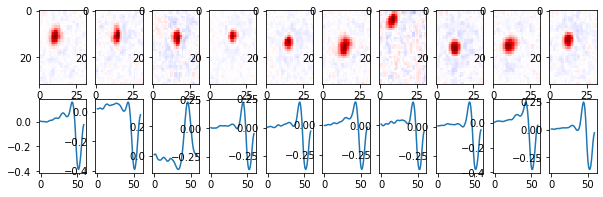

In [24]:
if p['rf_30m'] == 1:
    name_rf_30m = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'rf_30m')
    pd_rf_30m = ext.photodiode(data_dir + p['exp_name'] + '/' + name_rf_30m)
    elec_rf_30m = ext.electrode(data_dir + p['exp_name'] + '/' + name_rf_30m)

    maxtab_rf_30m, _ = spk.peakdet(pd_rf_30m, p['rf_30m_th'])

    us_factor_rf_30m = 4
    elec_ext_rf_30m = ext.split_trial(elec_rf_30m, maxtab_rf_30m, 
                                      start=0, last=2, every=2, per=2, 
                                      sample_rate=fs, mode='continuous')
    spikes_ext_rf_30m = []
    for cell in range(p['g_cell_num']):
        spikes_ext_rf_30m.append(ext.split_trial(spikes_rf_30m[cell], maxtab_rf_30m, 
                                                 start=0, last=2, every=2, per=2, 
                                                 sample_rate=fs, mode='discrete'))
    tbins_rf_30m = np.linspace(0, elec_ext_rf_30m[0].shape[0]/fs, us_factor_rf_30m * 54000 + 1)[:-1]
    bspk_rf_30m = np.stack([spk.binspikes(spikes_ext_rf_30m[cell][0], tbins_rf_30m)
                            for cell in range(p['g_cell_num'])])
    stim_rf_30m = ext.load_stimulus('2d_st_bin_wn_w8', mode='mono', two_dim=True)

    stim_us_rf_30m = st.upsample(stim_rf_30m, us_factor_rf_30m)[0]
    #stim_us_rf_30m -= np.mean(stim_us_rf_30m)
    #stim_us_rf_30m /= np.std(stim_us_rf_30m)
    stim_us_rf_30m -= 0.5
    stim_us_rf_30m *= 2
    stas_rf_30m = []
    for cell in range(p['g_cell_num']):
        sta_rf_30m, tax_rf_30m = ft.sta(tbins_rf_30m, stim_us_rf_30m, spikes_ext_rf_30m[cell][0], us_factor_rf_30m*15)
        stas_rf_30m.append(sta_rf_30m)

    stas_space_rf_30m = np.zeros((p['g_cell_num'], stim_rf_30m.shape[1], stim_rf_30m.shape[-1]))
    stas_time_rf_30m = np.zeros((p['g_cell_num'], us_factor_rf_30m*15))
    stas_ellipse_rf_30m = np.zeros((p['g_cell_num'], 5))
    stim_us_rf_30m = stim_us_rf_30m.astype(int)
    
    fig = plt.figure(figsize=(10, 3))
    for cell in range(p['g_cell_num']):
        space, time = ft.decompose(ft.smooth(stas_rf_30m[cell], spacesig=0.7, timesig=1))
        if np.max(space) < -np.min(space):
            space = -space
            time = -time
        stas_space_rf_30m[cell, :, :] = space
        stas_time_rf_30m[cell, :] = time
        try:
            center, widths, theta = ft.get_ellipse(space, sigma=1.0)
            stas_ellipse_rf_30m[cell, 0] = center[0]
            stas_ellipse_rf_30m[cell, 1] = center[1]
            stas_ellipse_rf_30m[cell, 2] = widths[0]
            stas_ellipse_rf_30m[cell, 3] = widths[1]
            stas_ellipse_rf_30m[cell, 4] = theta
        except:
            stas_ellipse_rf_30m[cell, 0] = np.nan
            stas_ellipse_rf_30m[cell, 1] = np.nan
            stas_ellipse_rf_30m[cell, 2] = np.nan
            stas_ellipse_rf_30m[cell, 3] = np.nan
            stas_ellipse_rf_30m[cell, 4] = np.nan
        ax = plt.subplot(2, p['g_cell_num'], cell+1)
        plt.imshow(space, cmap='seismic', vmin=-np.max(abs(space)), vmax=np.max(abs(space)), aspect='auto', interpolation='nearest')
        ax = plt.subplot(2, p['g_cell_num'], p['g_cell_num']+cell+1)
        plt.plot(time)
else:
    stim_us_rf_30m = np.nan
    bspk_rf_30m = np.nan
    tbins_rf_30m = np.nan

## 3. Unsorted experiment

### 3-01. Load 'line_w4' session

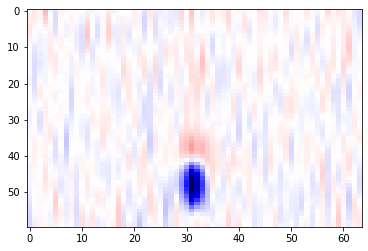

In [25]:
if p['line_w4'] == 1:
    name_line_w4 = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'line_w4')
    pd_line_w4 = ext.photodiode(data_dir + p['exp_name'] + '/notforsort/' + name_line_w4)
    elec_line_w4 = ext.electrode(data_dir + p['exp_name'] + '/notforsort/' + name_line_w4)

    maxtab_line_w4, _ = spk.peakdet(pd_line_w4, p['line_w4_th'])

    us_factor_line_w4 = 4
    elec_ext_line_w4 = ext.split_trial(elec_line_w4, maxtab_line_w4, 
                                       start=0, last=2, every=2, per=2, sample_rate=fs, mode='continuous')
    tbins_line_w4 = np.linspace(0, elec_ext_line_w4[0].shape[0]/fs, us_factor_line_w4 * 4500 + 1)[:-1]
    stim_line_w4 = ext.load_stimulus('1d_st_bin_wn_w4', mode='mono', two_dim=False)[:4500, :]

    stim_us_line_w4 = st.upsample(stim_line_w4, us_factor_line_w4)[0]
    #stim_us_line_w4 -= np.mean(stim_us_line_w4)
    #stim_us_line_w4 /= np.std(stim_us_line_w4)
    stim_us_line_w4 -= 0.5
    stim_us_line_w4 *= 2
    elec_ext_rs_line_w4 = scipy.signal.resample(st.downsample(elec_ext_line_w4[0], 10)[0], 
                                                stim_us_line_w4.shape[0])

    idx1_line_w4 = p['idx1_line_w4']
    idx2_line_w4 = p['idx2_line_w4']
    elec_ext_rs_cut_line_w4 = elec_ext_rs_line_w4[idx1_line_w4:idx2_line_w4]
    elec_ext_rs_cut_ft_line_w4 = utils.butter_lowpass_filter(
        utils.butter_highpass_filter(elec_ext_rs_cut_line_w4, fs=us_factor_line_w4*30.0), fs=us_factor_line_w4*30.0)
    elec_ext_rs_cut_ft_line_w4 -= np.mean(elec_ext_rs_cut_ft_line_w4)
    elec_ext_rs_cut_ft_line_w4 /= np.std(elec_ext_rs_cut_ft_line_w4)

    stim_us_cut_line_w4 = stim_us_line_w4[idx1_line_w4+1000:idx2_line_w4-1000]
    intra_line_w4 = elec_ext_rs_cut_ft_line_w4[1000:-1000]
    tbins_cut_line_w4 = tbins_line_w4[idx1_line_w4+1000:idx2_line_w4-1000]
    rc_line_w4 = ft.revcorr(stim_us_cut_line_w4, intra_line_w4, us_factor_line_w4*15)[0]
    stim_us_cut_line_w4 = stim_us_cut_line_w4.astype(int)
    plt.imshow(rc_line_w4, cmap='seismic', vmin=-np.max(abs(rc_line_w4)), vmax=np.max(abs(rc_line_w4)), interpolation='nearest', aspect='auto')

### 3-02. Load 'line_w8' session

In [26]:
if p['line_w8'] == 1:
    name_line_w8 = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'line_w8')
    pd_line_w8 = ext.photodiode(data_dir + p['exp_name'] + '/notforsort/' + name_line_w8)
    elec_line_w8 = ext.electrode(data_dir + p['exp_name'] + '/notforsort/' + name_line_w8)

    maxtab_line_w8, _ = spk.peakdet(pd_line_w8, p['line_w8_th'])

    us_factor_line_w8 = 4
    elec_ext_line_w8 = ext.split_trial(elec_line_w8, maxtab_line_w8, 
                                       start=0, last=2, every=2, per=2, sample_rate=fs, mode='continuous')
    tbins_line_w8 = np.linspace(0, elec_ext_line_w8[0].shape[0]/fs, us_factor_line_w8 * 4500 + 1)[:-1]
    stim_line_w8 = np.repeat(ext.load_stimulus('1d_st_bin_wn_w8', mode='mono', two_dim=False)[:4500, :], 
                             2, axis=1)

    stim_us_line_w8 = st.upsample(stim_line_w8, us_factor_line_w8)[0]
    #stim_us_line_w8 -= np.mean(stim_us_line_w8)
    #stim_us_line_w8 /= np.std(stim_us_line_w8)
    stim_us_line_w8 -= 0.5
    stim_us_line_w8 *= 2
    elec_ext_rs_line_w8 = scipy.signal.resample(st.downsample(elec_ext_line_w8[0], 10)[0], 
                                                stim_us_line_w8.shape[0])

    idx1_line_w8 = p['idx1_line_w8']
    idx2_line_w8 = p['idx2_line_w8']
    elec_ext_rs_cut_line_w8 = elec_ext_rs_line_w8[idx1_line_w8:idx2_line_w8]
    elec_ext_rs_cut_ft_line_w8 = utils.butter_lowpass_filter(
        utils.butter_highpass_filter(elec_ext_rs_cut_line_w8, fs=us_factor_line_w8*30.0), fs=us_factor_line_w8*30.0)
    elec_ext_rs_cut_ft_line_w8 -= np.mean(elec_ext_rs_cut_ft_line_w8)
    elec_ext_rs_cut_ft_line_w8 /= np.std(elec_ext_rs_cut_ft_line_w8)

    stim_us_cut_line_w8 = stim_us_line_w8[idx1_line_w8+1000:idx2_line_w8-1000]
    intra_line_w8 = elec_ext_rs_cut_ft_line_w8[1000:-1000]
    tbins_cut_line_w8 = tbins_line_w8[idx1_line_w8+1000:idx2_line_w8-1000]
    rc_line_w8 = ft.revcorr(stim_us_cut_line_w8, intra_line_w8, us_factor_line_w8*15)[0]
    stim_us_cut_line_w8 = stim_us_cut_line_w8.astype(int)
    plt.imshow(rc_line_w8, cmap='seismic', vmin=-np.max(abs(rc_line_w8)), vmax=np.max(abs(rc_line_w8)), interpolation='nearest', aspect='auto')

### 3-03. Load 'rf_5m' session

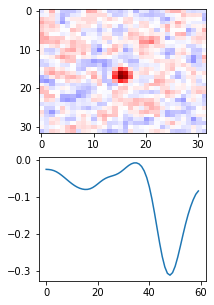

In [27]:
if p['rf_5m'] == 1:
    name_rf_5m = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'rf_5m')
    pd_rf_5m = ext.photodiode(data_dir + p['exp_name'] + '/notforsort/' + name_rf_5m)
    elec_rf_5m = ext.electrode(data_dir + p['exp_name'] + '/notforsort/' + name_rf_5m)

    maxtab_rf_5m, _ = spk.peakdet(pd_rf_5m, p['rf_5m_th'])

    us_factor_rf_5m = 4
    elec_ext_rf_5m = ext.split_trial(elec_rf_5m, maxtab_rf_5m, 
                                     start=0, last=2, every=2, per=2, sample_rate=fs, mode='continuous')
    tbins_rf_5m = np.linspace(0, elec_ext_rf_5m[0].shape[0]/fs, us_factor_rf_5m * 9000 + 1)[:-1]
    stim_rf_5m = ext.load_stimulus('2d_st_bin_wn_w8', mode='mono', two_dim=True)[:9000, :, :]

    stim_us_rf_5m = st.upsample(stim_rf_5m, us_factor_rf_5m)[0]
    #stim_us_rf_5m -= np.mean(stim_us_rf_5m)
    #stim_us_rf_5m /= np.std(stim_us_rf_5m)
    stim_us_rf_5m -= 0.5
    stim_us_rf_5m *= 2
    elec_ext_rs_rf_5m = scipy.signal.resample(st.downsample(elec_ext_rf_5m[0], 10)[0], stim_us_rf_5m.shape[0])

    idx1_rf_5m = p['idx1_rf_5m']
    idx2_rf_5m = p['idx2_rf_5m']
    elec_ext_rs_cut_rf_5m = elec_ext_rs_rf_5m[idx1_rf_5m:idx2_rf_5m]
    elec_ext_rs_cut_ft_rf_5m = utils.butter_lowpass_filter(
        utils.butter_highpass_filter(elec_ext_rs_cut_rf_5m, fs=us_factor_rf_5m*30.0), fs=us_factor_rf_5m*30.0)
    elec_ext_rs_cut_ft_rf_5m -= np.mean(elec_ext_rs_cut_ft_rf_5m)
    elec_ext_rs_cut_ft_rf_5m /= np.std(elec_ext_rs_cut_ft_rf_5m)

    stim_us_cut_rf_5m = stim_us_rf_5m[idx1_rf_5m+1000:idx2_rf_5m-1000]
    intra_rf_5m = elec_ext_rs_cut_ft_rf_5m[1000:-1000]
    tbins_cut_rf_5m = tbins_rf_5m[idx1_rf_5m+1000:idx2_rf_5m-1000]
    rc_rf_5m = ft.revcorr(stim_us_cut_rf_5m, intra_rf_5m, us_factor_rf_5m*15)[0]
    stim_us_cut_rf_5m = stim_us_cut_rf_5m.astype(int)
    rc_space_rf_5m, rc_time_rf_5m = ft.decompose(ft.smooth(rc_rf_5m, spacesig=0.7, timesig=1))
    if np.max(rc_space_rf_5m) < -np.min(rc_space_rf_5m):
        rc_space_rf_5m = -rc_space_rf_5m
        rc_time_rf_5m = -rc_time_rf_5m
    center_i, widths_i, theta_i = ft.get_ellipse(rc_space_rf_5m, sigma=1.0)
    rc_ellipse_rf_5m = np.zeros((5,))
    rc_ellipse_rf_5m[0] = center_i[0]
    rc_ellipse_rf_5m[1] = center_i[1]
    rc_ellipse_rf_5m[2] = widths_i[0]
    rc_ellipse_rf_5m[3] = widths_i[1]
    rc_ellipse_rf_5m[4] = theta_i

    fig = plt.figure(figsize=(3, 5))
    ax = plt.subplot(2, 1, 1)
    plt.imshow(rc_space_rf_5m, cmap='seismic', vmin=-np.max(abs(rc_space_rf_5m)), vmax=np.max(abs(rc_space_rf_5m)), aspect='auto', interpolation='nearest')
    ax = plt.subplot(2, 1, 2)
    plt.plot(rc_time_rf_5m)
else:
    stim_us_cut_rf_5m = np.nan
    intra_rf_5m = np.nan
    tbins_cut_rf_5m = np.nan

### 3-04. Load 'mb' session

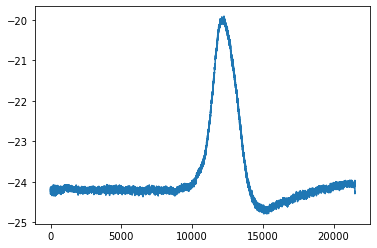

In [28]:
if p['mb'] == 1:
    name_mb = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'mb')
    pd_mb = ext.photodiode(data_dir + p['exp_name'] + '/notforsort/' + name_mb)
    elec_mb = ext.electrode(data_dir + p['exp_name'] + '/notforsort/' + name_mb)

    maxtab_mb, _ = spk.peakdet(pd_mb, p['mb_th'])

    stim_mb = ext.load_stimulus_mb()
    elec_ext_mb = ext.split_trial(elec_mb, maxtab_mb, 
                                  start=0, last=80, every=2, per=1, sample_rate=fs, mode='continuous')
    tbins_mb = np.arange(0, 129 * fr, fr)

    mb_lr_idx = np.outer(mb_idx, lr_idx).reshape(-1)
    mb_rl_idx = np.outer(mb_idx, rl_idx).reshape(-1)
    elec_ext_mb_lr = ext.list_to_array(elec_ext_mb, ndim=1)[:, :21500][mb_lr_idx == 1]
    elec_ext_mb_rl = ext.list_to_array(elec_ext_mb, ndim=1)[:, :21500][mb_rl_idx == 1]

    intra_mb = np.stack([elec_ext_mb_lr, elec_ext_mb_rl])

    plt.plot(np.nanmean(elec_ext_mb_lr, axis=0))
else:
    stim_mb = np.nan
    intra_mb = np.nan
    tbins_mb = np.nan

### 3-05. Load 'flash_2' session

In [29]:
if p['flash_2'] == 1:
    name_flash_2 = utils.file_name(p['exp_date'], p['retina_idx'], p['intracell_idx'], 'flash_2')
    pd_flash_2 = ext.photodiode(data_dir + p['exp_name'] + '/notforsort/' + name_flash_2)
    elec_flash_2 = ext.electrode(data_dir + p['exp_name'] + '/notforsort/' + name_flash_2)

    maxtab_flash_2, _ = spk.peakdet(pd_flash_2, p['flash_2_th'])

    elec_ext_flash_2 = ext.split_trial(elec_flash_2, maxtab_flash_2, 
                                       start=0, last=20, every=2, per=2, sample_rate=fs, mode='continuous')
    tbins_flash_2 = np.arange(0, 122 * fr, fr)
    stim_flash_2 = np.concatenate((np.ones(61), np.zeros(61)))
    intra_flash_2 = ext.list_to_array(elec_ext_flash_2, ndim=1)

    plt.plot(np.nanmean(utils.butter_highpass_filter(ext.list_to_array(elec_ext_flash_2, ndim=1)), axis=0) + 
             np.nanmean(ext.list_to_array(elec_ext_flash_2, ndim=1)))
else:
    stim_flash_2 = np.nan
    intra_flash_2 = np.nan
    tbins_flash_2 = np.nan

## 4. Injected current (analog output)

### 4-01. Load 'mb_ad_ao' session

In [30]:
if p['mb_ad_ao'] == 1:
    name_mb_ad_ao = '-'.join(['c' + str(p['intracell_idx']), 'mb-ad-ao.h5'])
    with h5py.File(data_dir + p['exp_name'] + '/notforsort/' + name_mb_ad_ao, 'r') as f_mb_ad_ao:
        inj_mb_ad_ao = np.double(f_mb_ad_ao['analog-output'])

    if p['mb_4ad'] == 1:
        maxtab_mb_ad_ao = maxtab_mb_4ad
    elif p['mb_2ad'] == 1:
        maxtab_mb_ad_ao = maxtab_mb_2ad
    elif p['mb_ad'] == 1:
        maxtab_mb_ad_ao = maxtab_mb_ad
    else:
        print("No maxtab to use as reference!")

    N_inj_mb_ad_ao = maxtab_mb_ad_ao.shape[0]
    inj_ext_mb_ad_ao = ext.split_trial(inj_mb_ad_ao, maxtab_mb_ad_ao, 
                                       start=0, last=N_inj_mb_ad_ao, every=2, per=1, 
                                       sample_rate=fs, mode='continuous')
    tbins_mb_ad_ao = np.arange(0, 129 * fr, fr)

    mb_ad_ao_con_lr_idx = np.outer(con_idx, lr_idx).reshape(-1)
    mb_ad_ao_amp_lr_idx = np.outer(pb1_idx, lr_idx).reshape(-1)
    mb_ad_ao_dim_lr_idx = np.outer(pb2_idx, lr_idx).reshape(-1)
    mb_ad_ao_con_rl_idx = np.outer(con_idx, rl_idx).reshape(-1)
    mb_ad_ao_amp_rl_idx = np.outer(pb1_idx, rl_idx).reshape(-1)
    mb_ad_ao_dim_rl_idx = np.outer(pb2_idx, rl_idx).reshape(-1)
    inj_ext_mb_ad_ao_con_lr = ext.list_to_array(inj_ext_mb_ad_ao, ndim=1)[:, :21500][mb_ad_ao_con_lr_idx == 1]
    inj_ext_mb_ad_ao_amp_lr = ext.list_to_array(inj_ext_mb_ad_ao, ndim=1)[:, :21500][mb_ad_ao_amp_lr_idx == 1]
    inj_ext_mb_ad_ao_dim_lr = ext.list_to_array(inj_ext_mb_ad_ao, ndim=1)[:, :21500][mb_ad_ao_dim_lr_idx == 1]
    inj_ext_mb_ad_ao_con_rl = ext.list_to_array(inj_ext_mb_ad_ao, ndim=1)[:, :21500][mb_ad_ao_con_rl_idx == 1]
    inj_ext_mb_ad_ao_amp_rl = ext.list_to_array(inj_ext_mb_ad_ao, ndim=1)[:, :21500][mb_ad_ao_amp_rl_idx == 1]
    inj_ext_mb_ad_ao_dim_rl = ext.list_to_array(inj_ext_mb_ad_ao, ndim=1)[:, :21500][mb_ad_ao_dim_rl_idx == 1]

    if p['exp_version'] == 1:
        inj_total_mb_ad_ao = np.stack(
            [np.stack([np.vstack([inj_ext_mb_ad_ao_con_lr, np.full(inj_ext_mb_ad_ao_con_lr.shape, np.nan)]),
                        inj_ext_mb_ad_ao_amp_lr, inj_ext_mb_ad_ao_dim_lr], axis=0),
             np.stack([np.vstack([inj_ext_mb_ad_ao_con_rl, np.full(inj_ext_mb_ad_ao_con_rl.shape, np.nan)]), 
                        inj_ext_mb_ad_ao_amp_rl, inj_ext_mb_ad_ao_dim_rl], axis=0)], axis=0)
    else:
        inj_total_mb_ad_ao = np.stack(
            [np.stack([inj_ext_mb_ad_ao_con_lr, inj_ext_mb_ad_ao_amp_lr, inj_ext_mb_ad_ao_dim_lr], axis=0),
             np.stack([inj_ext_mb_ad_ao_con_rl, inj_ext_mb_ad_ao_amp_rl, inj_ext_mb_ad_ao_dim_rl], axis=0)], axis=0)
else:
    inj_total_mb_ad_ao = np.nan
    tbins_mb_ad_ao = np.nan

### 4-02. Load 'wn_500_ao' session

In [31]:
if p['rf_wn'] == 1:
    with h5py.File(proj_dir + 'matrix/wn-500-ao.h5', 'r') as f_wn_500_ao:
        inj_rf_wn = np.double(f_wn_500_ao['analog-output'])

    inj_ext_rf_wn = ext.split_trial(inj_rf_wn, maxtab_rf_wn, 
                                    start=0, last=2, every=2, per=2, sample_rate=fs, mode='continuous')
    inj_ext_rs_rf_wn = scipy.signal.resample(st.downsample(inj_ext_rf_wn[0], 10)[0], stim_us_rf_wn.shape[0])

## 5. Check sign of injected current

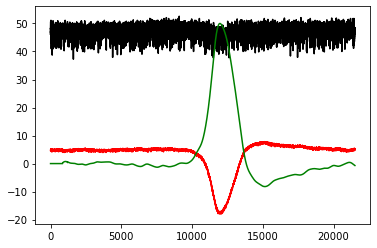

In [32]:
if p['mb_ad'] == 1:
    plt.plot(10*elec_ext_mb_ad[0], 'k')
    plt.plot(elec_ext_mb_ad[8], 'r')
    plt.plot(100*inj_ext_mb_ad_ao_amp_lr[0], 'g')
else:
    print(1)

In [33]:
if p['mb_2ad'] == 1:
    plt.plot(10*elec_ext_mb_2ad[0], 'k')
    plt.plot(elec_ext_mb_2ad[8], 'r')
    plt.plot(100*inj_ext_mb_ad_ao_amp_lr[0], 'g')
else:
    print(1)

1


In [34]:
if p['mb_4ad'] == 1:
    plt.plot(10*elec_ext_mb_4ad[0], 'k')
    plt.plot(elec_ext_mb_4ad[8], 'r')
    plt.plot(100*inj_ext_mb_ad_ao_amp_lr[0], 'g')
else:
    print(1)

1


## 6. Save as new .h5 file

In [85]:
if SAVE_TO_HDF5 == 1:
    with h5py.File(proj_dir + 'data-extract/' + config['sort_version'] + '/' + p['exp_name'] + '_extract'+ '.h5', 'w') as f:
        #f.create_dataset('sort/', data=np.array([]))
        f.create_dataset('sort/flash_1/stim', data=stim_flash_1)
        f.create_dataset('sort/flash_1/ganglion', data=bspk_flash_1)
        f.create_dataset('sort/flash_1/intracell', data=intra_flash_1)
        f.create_dataset('sort/flash_1/tbins', data=tbins_flash_1)      # 10000.0 Hz
        
        f.create_dataset('sort/rf_wn/stim', data=stim_us_rf_wn)
        f.create_dataset('sort/rf_wn/ganglion', data=bspk_rf_wn)
        f.create_dataset('sort/rf_wn/intracell', data=inj_ext_rs_rf_wn) # inject
        f.create_dataset('sort/rf_wn/tbins', data=tbins_rf_wn)
        
        f.create_dataset('sort/mb_ns/stim', data=np.nan)
        f.create_dataset('sort/mb_ns/ganglion', data=bspk_total_mb_ns)
        f.create_dataset('sort/mb_ns/intracell', data=np.nan)           # inject (mb_ad_ns)
        f.create_dataset('sort/mb_ns/tbins', data=tbins_mb_ns)
        
        f.create_dataset('sort/mb_ad/stim', data=stim_mb)
        f.create_dataset('sort/mb_ad/ganglion', data=bspk_total_mb_ad)
        f.create_dataset('sort/mb_ad/intracell', data=np.nan)           # inject (mb_ad_ao)
        f.create_dataset('sort/mb_ad/tbins', data=tbins_mb_ad)
        
        f.create_dataset('sort/mb_da/stim', data=stim_mb)
        f.create_dataset('sort/mb_da/ganglion', data=bspk_total_mb_da)
        f.create_dataset('sort/mb_da/intracell', data=np.nan)           # inject (mb_da_ao)
        f.create_dataset('sort/mb_da/tbins', data=tbins_mb_da)
                         
        f.create_dataset('sort/mb_2ad/stim', data=stim_mb)
        f.create_dataset('sort/mb_2ad/ganglion', data=bspk_total_mb_2ad)
        f.create_dataset('sort/mb_2ad/intracell', data=np.nan)          # inject (mb_2ad_ao)
        f.create_dataset('sort/mb_2ad/tbins', data=tbins_mb_2ad)
        
        f.create_dataset('sort/mb_4ad/stim', data=stim_mb)
        f.create_dataset('sort/mb_4ad/ganglion', data=bspk_total_mb_4ad)
        f.create_dataset('sort/mb_4ad/intracell', data=np.nan)          # inject (mb_4ad_ao)
        f.create_dataset('sort/mb_4ad/tbins', data=tbins_mb_4ad)
        
        f.create_dataset('sort/mb_2da/stim', data=stim_mb)
        f.create_dataset('sort/mb_2da/ganglion', data=bspk_total_mb_2da)
        f.create_dataset('sort/mb_2da/intracell', data=np.nan)          # inject (mb_2da_ao)
        f.create_dataset('sort/mb_2da/tbins', data=tbins_mb_2da)
        
        f.create_dataset('sort/mb_4da/stim', data=stim_mb)
        f.create_dataset('sort/mb_4da/ganglion', data=bspk_total_mb_4da)
        f.create_dataset('sort/mb_4da/intracell', data=np.nan)          # inject (mb_4da_ao)
        f.create_dataset('sort/mb_4da/tbins', data=tbins_mb_4da)
        
        f.create_dataset('sort/rf_30m/stim', data=stim_us_rf_30m, dtype='i')
        f.create_dataset('sort/rf_30m/ganglion', data=bspk_rf_30m)
        f.create_dataset('sort/rf_30m/intracell', data=np.nan)
        f.create_dataset('sort/rf_30m/tbins', data=tbins_rf_30m)
        
        #f.create_dataset('unsort/', data=np.array([]))
        if p['line_w4'] == 1:
            f.create_dataset('unsort/line/stim', data=stim_us_cut_line_w4, dtype='i')
            f.create_dataset('unsort/line/ganglion', data=np.nan)
            f.create_dataset('unsort/line/intracell', data=intra_line_w4)
            f.create_dataset('unsort/line/tbins', data=tbins_cut_line_w4)
        elif p['line_w8'] == 1:
            f.create_dataset('unsort/line/stim', data=stim_us_cut_line_w8, dtype='i')
            f.create_dataset('unsort/line/ganglion', data=np.nan)
            f.create_dataset('unsort/line/intracell', data=intra_line_w8)
            f.create_dataset('unsort/line/tbins', data=tbins_cut_line_w8)
        
        f.create_dataset('unsort/rf_5m/stim', data=stim_us_cut_rf_5m, dtype='i')
        f.create_dataset('unsort/rf_5m/ganglion', data=np.nan)
        f.create_dataset('unsort/rf_5m/intracell', data=intra_rf_5m)
        f.create_dataset('unsort/rf_5m/tbins', data=tbins_cut_rf_5m)
        
        f.create_dataset('unsort/mb/stim', data=stim_mb)
        f.create_dataset('unsort/mb/ganglion', data=np.nan)
        f.create_dataset('unsort/mb/intracell', data=intra_mb)
        f.create_dataset('unsort/mb/tbins', data=tbins_mb)
        
        f.create_dataset('unsort/flash_2/stim', data=stim_flash_2)
        f.create_dataset('unsort/flash_2/ganglion', data=np.nan)
        f.create_dataset('unsort/flash_2/intracell', data=intra_flash_2)
        f.create_dataset('unsort/flash_2/tbins', data=tbins_flash_2) # 10000.0 Hz
        
        #f.create_dataset('etc/', data=np.array([]))
        f.create_dataset('etc/mb_ad_ao/stim', data=stim_mb)
        f.create_dataset('etc/mb_ad_ao/ganglion', data=np.nan)
        f.create_dataset('etc/mb_ad_ao/intracell', data=inj_total_mb_ad_ao)
        f.create_dataset('etc/mb_ad_ao/tbins', data=tbins_mb_ad_ao)
        
        #f.create_dataset('rf/', data=np.array([]))
        f.create_dataset('rf/ganglion/st', data=np.stack(stas_rf_30m))
        f.create_dataset('rf/ganglion/space', data=stas_space_rf_30m)
        f.create_dataset('rf/ganglion/time', data=stas_time_rf_30m)
        f.create_dataset('rf/ganglion/ellipse', data=stas_ellipse_rf_30m)
        
        f.create_dataset('rf/intracell/st', data=rc_rf_5m)
        if p['line_w4'] == 1:
            f.create_dataset('rf/intracell/line', data=rc_line_w4)
        elif p['line_w8'] == 1:
            f.create_dataset('rf/intracell/line', data=rc_line_w8)
        f.create_dataset('rf/intracell/space', data=rc_space_rf_5m)
        f.create_dataset('rf/intracell/time', data=rc_time_rf_5m)
        f.create_dataset('rf/intracell/ellipse', data=rc_ellipse_rf_5m)

In [86]:
if SAVE_SPIKES_TO_PICKLE == 1:
    pickle.dump(spikes_ext_mb_ad, open(proj_dir + 'data-extract/' + config['sort_version'] + '/' + p['exp_name'] + '_extract_spikes_mb_ad'+ '.p', 'wb'))

#### 